## GuitarSet baseline


web : https://guitarset.weebly.com/ <br>
download : https://zenodo.org/record/3371780#.Y3DnWXZByUk <br>
visualize : https://github.com/marl/GuitarSet/tree/master/visualize


In [1]:
import jams
import os
import re
import numpy as np
from collections import defaultdict

import tensorflow as tf

import matplotlib.pyplot as plt
import librosa.display  #for music and audio analysis
import librosa          #for music and audio analysis

import scipy
from scipy.io import wavfile
import scipy.signal as sps

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2023-01-03 11:02:39.114150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 11:02:39.233598: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-03 11:02:39.746908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 11:02:39.746943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

### Data load

In [2]:
ori_wav_path = 'data/audio_hex-pickup_original/'
mono_wav_path = 'data/audio_mono_pickup-mic/'
anno_path = 'data/annotation/'

### EDA

In [3]:
# annotation files

max_n_chord = 0
min_n_chord = np.inf
duration_list = []
chord_list = []
for file_name in os.listdir(anno_path):
    jam = jams.load(anno_path + file_name)

    instructed_chord_list = jam.search(namespace='chord')[0]
    instructed_chord_list_data = instructed_chord_list['data']

    if max_n_chord < len(instructed_chord_list_data):
      max_n_chord = len(instructed_chord_list_data)

    if min_n_chord > len(instructed_chord_list_data):
      min_n_chord = len(instructed_chord_list_data)

    for item in instructed_chord_list_data:
      chord = item.value
      duration_list.append(item.duration)
      if chord not in chord_list:
        chord_list.append(chord)
      
print('Max number of chord in all wave        : ', max_n_chord)
print('Min number of chord in all wave        : ', min_n_chord)
print('Max length of duration in all wave     : ', np.max(duration_list))
print('Min length of duration in all wave     : ', np.min(duration_list))
print('Number of Annotation chord (=duration) : ', len(chord_list))
print('Chord_list \n', chord_list)

Max number of chord in all wave        :  16
Min number of chord in all wave        :  6
Max length of duration in all wave     :  14.117647058823529
Min length of duration in all wave     :  1.1999999999999993
Number of Annotation chord (=duration) :  42
Chord_list 
 ['C:maj', 'G:maj', 'A:min', 'E:min', 'F:maj', 'C#:min', 'F#:7', 'B:maj', 'E:maj', 'A#:hdim7', 'D#:7', 'G#:min', 'A:maj', 'F#:min', 'D:maj', 'G:min', 'C:7', 'A#:maj', 'E:hdim7', 'A:7', 'D:min', 'D#:maj', 'G#:maj', 'C#:maj', 'F#:maj', 'C#:7', 'F:hdim7', 'A#:7', 'D#:min', 'A#:min', 'G:hdim7', 'F:min', 'B:min', 'E:7', 'G#:hdim7', 'C#:hdim7', 'C:min', 'G#:7', 'C:hdim7', 'F:7', 'A:hdim7', 'D:7']


number of duration (=chord) :  4320
Max length of duration      :  1.1999999999999993
Avg. length of duration     :  2.53899
Median length of duration   :  2.142857142857143
Max length of duration      :  14.117647058823529


(array([3108.,  768.,  216.,   84.,   84.,   12.,   24.,   12.,    0.,
          12.]),
 array([ 1.2       ,  2.49176471,  3.78352941,  5.07529412,  6.36705882,
         7.65882353,  8.95058824, 10.24235294, 11.53411765, 12.82588235,
        14.11764706]),
 <BarContainer object of 10 artists>)

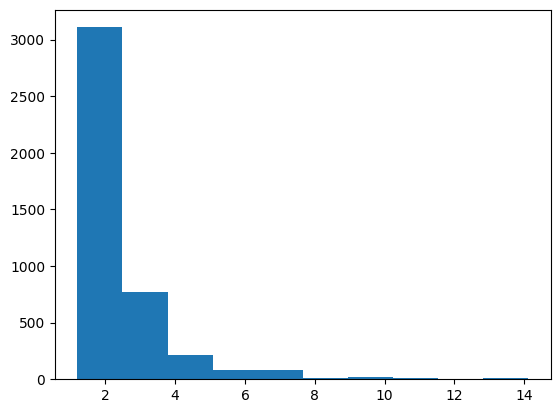

In [4]:
print('number of duration (=chord) : ', len(duration_list))
print('Max length of duration      : ', np.min(duration_list))
print('Avg. length of duration     : ', np.mean(duration_list))
print('Median length of duration   : ', np.median(duration_list))
print('Max length of duration      : ', np.max(duration_list))
plt.hist(duration_list)

In [5]:
outlier_bench = 5
outliers = [x for x in duration_list if x > outlier_bench]

print(len(outliers))

228


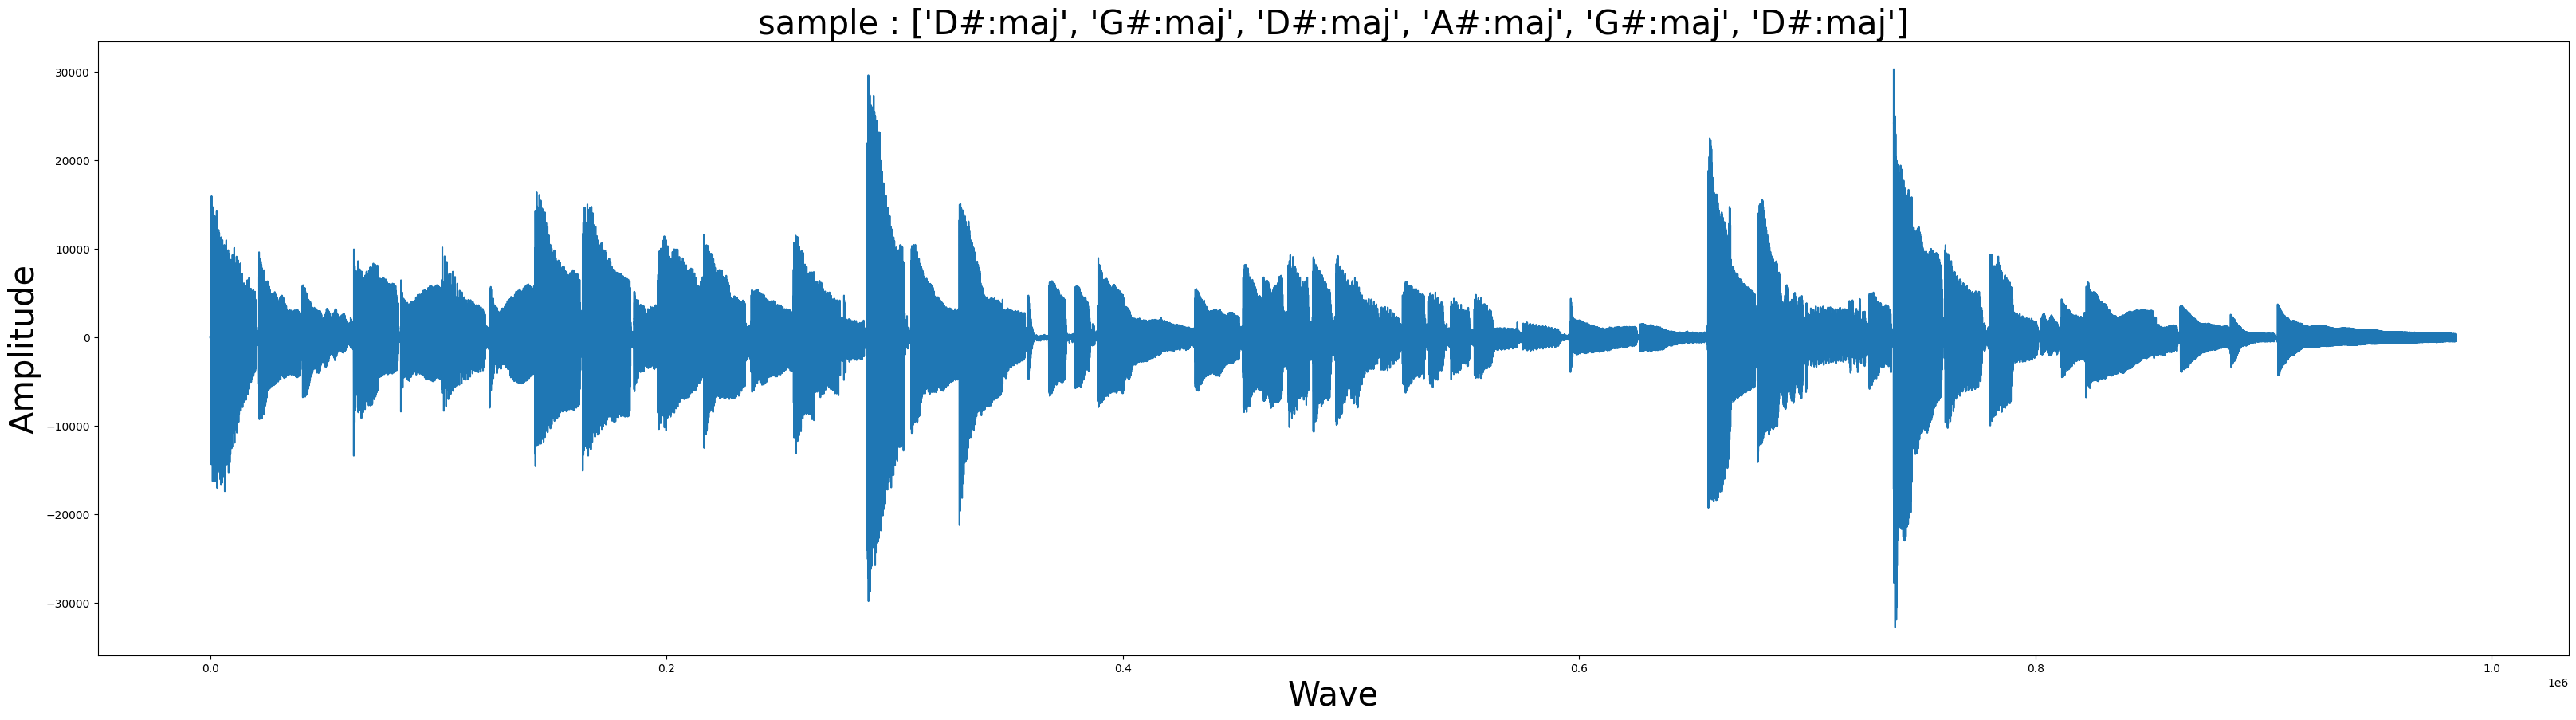

In [6]:
# wave and annotation sample

file_name = '00_BN1-129-Eb_solo'

fs, wave = wavfile.read(mono_wav_path + file_name +'_mix.wav')  # data length = frequency * wave length
jam = jams.load(anno_path + file_name+'.jams')

instructed_chords = jam.search(namespace='chord')[0]
instructed_chords_data = instructed_chords['data']

sample_chords = []
for item in  instructed_chords_data:
    sample_chords.append(item.value)

plt.figure(figsize=(40,10))

plt.plot(wave)
plt.title("sample : {}".format(sample_chords), fontsize = 30)
plt.xlabel('Wave', fontsize = 30)
plt.ylabel('Amplitude', fontsize = 30)

plt.show()


### Preprocessing


In [7]:
# Chords encoding

cnvt_chords = []
for c in chord_list:
    cnvt_c = c.split(':')[0]
    if cnvt_c not in cnvt_chords:
        cnvt_chords.append(cnvt_c)

le_chords = LabelEncoder()
le_chords.fit(cnvt_chords)

# le_chords = LabelEncoder()
# le_chords.fit(chord_list)

print(le_chords.classes_)

['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


In [8]:
frequency = 44100

waves = []
targets = []
for file_name in os.listdir(anno_path):
    file_name = file_name.split('.')[0]

    # wav file
    _, wave = wavfile.read(mono_wav_path + file_name + '_mix.wav')  # data length = frequency * wave length

    # annotation file
    jam = jams.load(anno_path + file_name + '.jams')
    instructed_chords = jam.search(namespace='chord')[0]
    instructed_chords_data = instructed_chords['data']

    resampled_waves = []
    chords = []
    for item in instructed_chords_data:
        start_time = item.time
        end_time = item.time + item.duration
        chord = item.value.split(':')[0]                        # convert to briefly  ex) C:min, C:maj, -> C
        # chord = item.value

        if end_time - start_time > outlier_bench:               # outlier_bench : 5s
            continue

        start_wave = int(frequency * start_time)
        end_wave = int(frequency * end_time)

        shorts_wave = wave[start_wave:end_wave].tolist()

        # down sampling (44100 -> 22050)
        new_frequency = 22050
        goal_len = round(len(shorts_wave)*float(new_frequency)/frequency)
        sampled_wave = sps.resample(shorts_wave, goal_len)

        resampled_waves.append(sampled_wave)
        chords.append(le_chords.transform([chord]))

    waves.extend(resampled_waves)
    targets.extend(chords)

print('success')

success


In [9]:
print('Number of waves              : ', np.array(waves).shape)
print('Number of targets            : ', np.array(targets).shape)
print('Sample of waves shape        : ', waves[0].shape)
print('Sample of annotation shape   : ', targets[0].shape)
print('Sample of encoded annotation : ', targets[0].tolist())
print('Sample of actual annotation  : ', le_chords.inverse_transform(np.array(targets[0])))

Number of waves              :  (4092,)
Number of targets            :  (4092, 1)
Sample of waves shape        :  (35280,)
Sample of annotation shape   :  (1,)
Sample of encoded annotation :  [3]
Sample of actual annotation  :  ['C']


/tmp/ipykernel_1847/413263172.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print('Number of waves              : ', np.array(waves).shape)


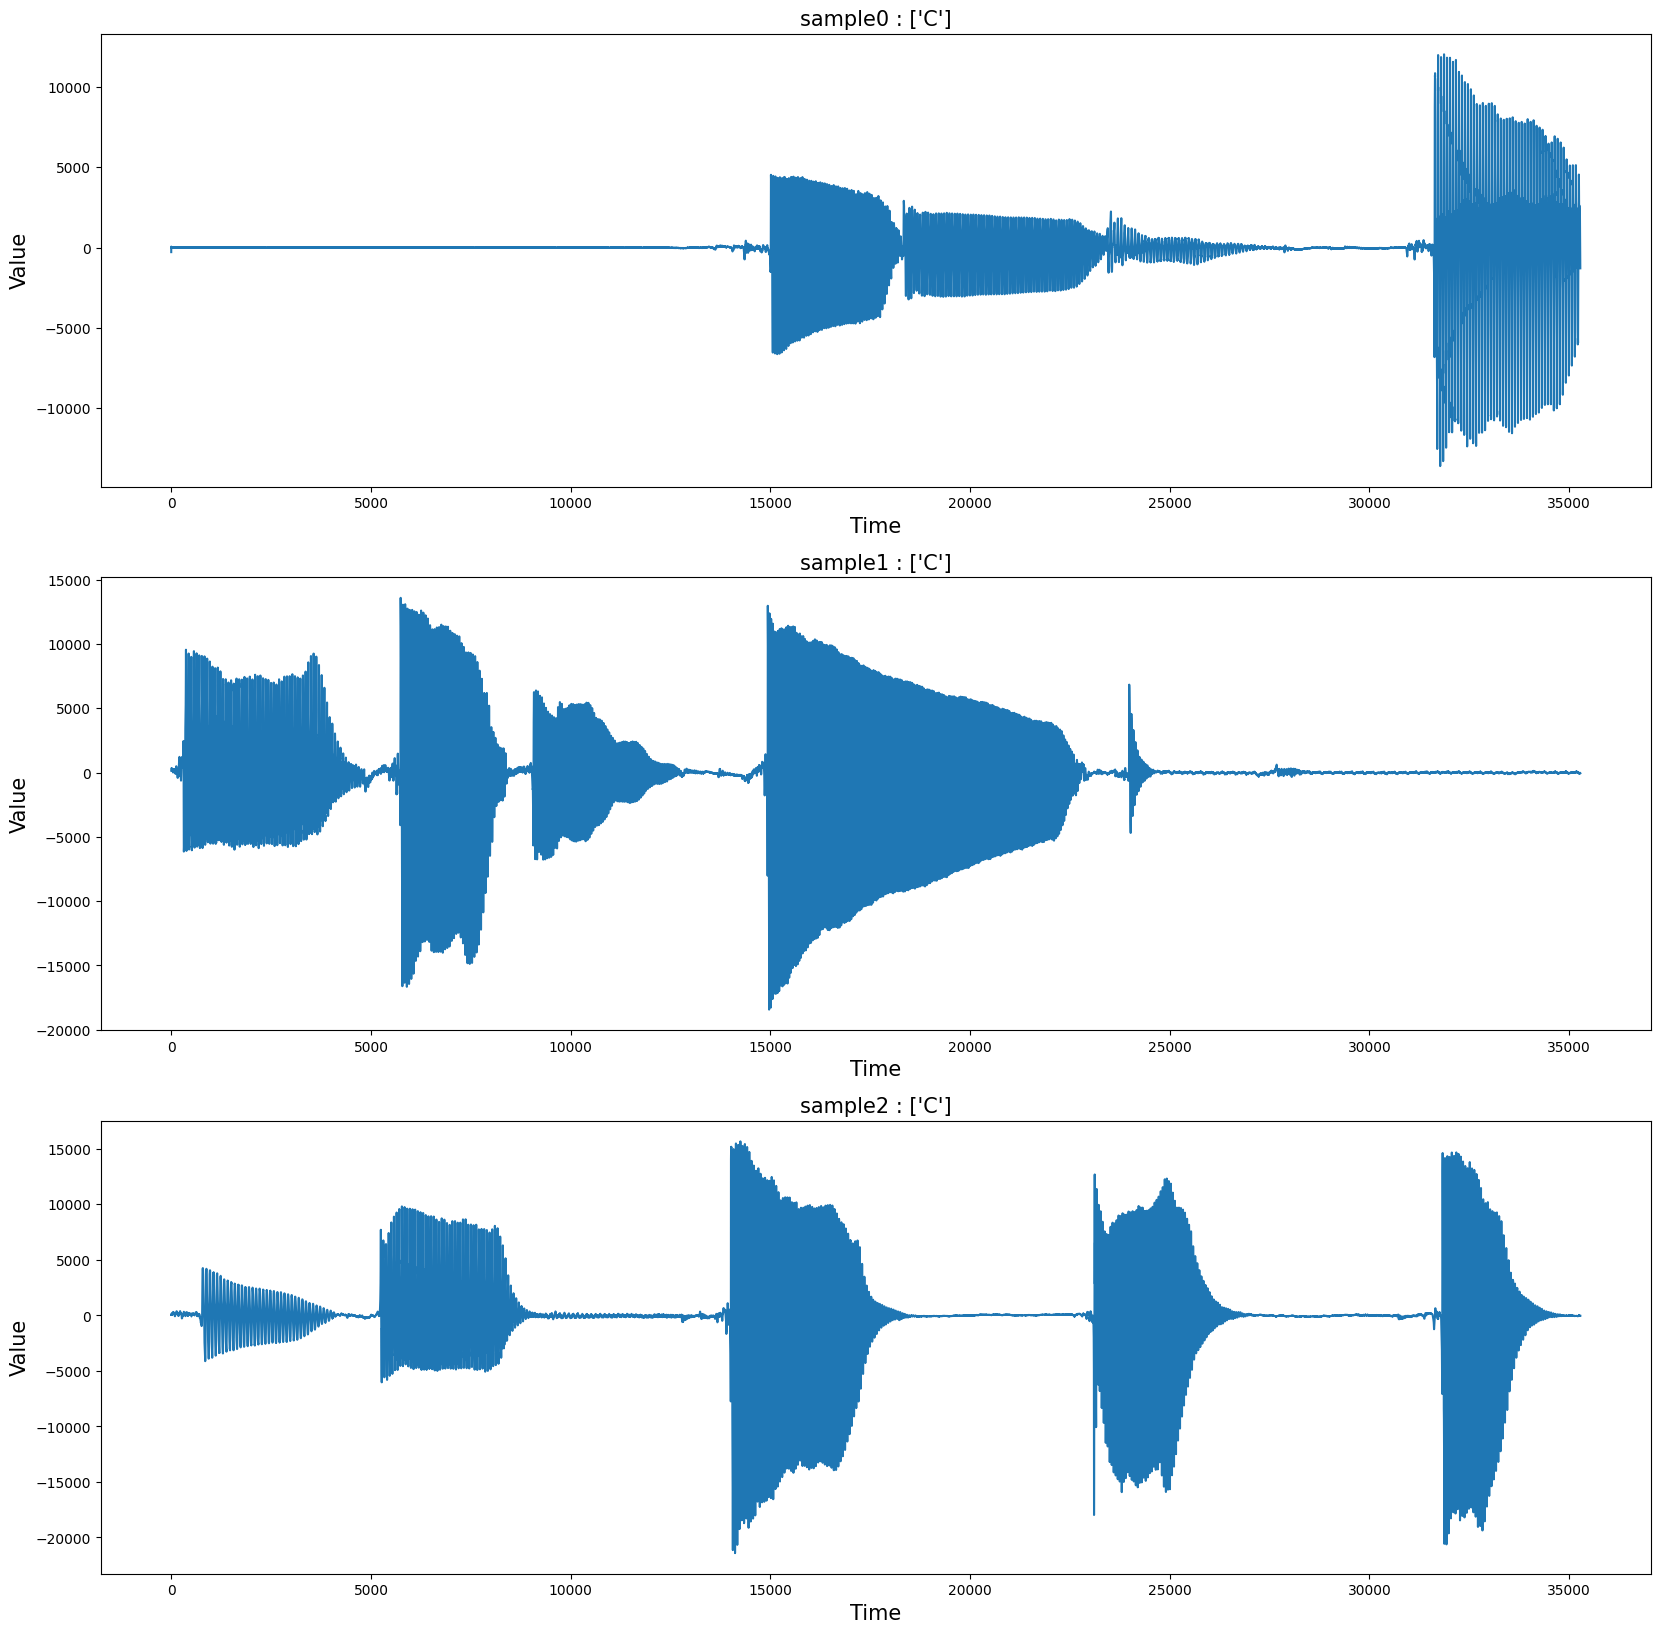

In [10]:
fig, axes = plt.subplots(3,1, figsize = (20,20))

wave_10_chord = le_chords.inverse_transform(targets[0].tolist())
wave_20_chord = le_chords.inverse_transform(targets[5].tolist())
wave_30_chord = le_chords.inverse_transform(targets[8].tolist())

axes[0].plot(waves[0])
axes[0].set_title("sample0 : {}".format(wave_10_chord), fontsize = 15)
axes[0].set_xlabel('Time', fontsize = 15)
axes[0].set_ylabel('Value', fontsize = 15)

axes[1].plot(waves[5])
axes[1].set_title("sample1 : {}".format(wave_20_chord), fontsize = 15)
axes[1].set_xlabel('Time', fontsize = 15)
axes[1].set_ylabel('Value', fontsize = 15)

axes[2].plot(waves[8])
axes[2].set_title("sample2 : {}".format(wave_30_chord), fontsize = 15)
axes[2].set_xlabel('Time', fontsize = 15)
axes[2].set_ylabel('Value', fontsize = 15)

plt.show()

In [11]:
# data augmentation by adding a white noise

noise_rate = 0.005
arg_waves = []
arg_targets = []
for w,t in zip(waves, targets):
    wn = np.random.randn(len(w))
    wn_wave = w + noise_rate*wn
    arg_waves.append(wn_wave)
    arg_targets.append(t)

waves.extend(arg_waves)
targets.extend(arg_targets)

print(np.array(waves).shape)
print(np.array(targets).shape)

(8184,)
(8184, 1)


/tmp/ipykernel_1847/2273048964.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(waves).shape)


In [ ]:
# MFCC (mel frequency cepstral coefficient) & Mel spectrogram
# with padding to match the length of the data

def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')

  return mels


sampling_rate = 44100
mels_waves = []
mfcc_waves = []
for w in waves:
    mels_signal = librosa.feature.melspectrogram(y = w, sr = sampling_rate, n_mels=100)
    mels_signal = librosa.power_to_db(mels_signal, ref=np.max)
    mels_signal = random_pad(mels_signal, pad_size=250, mfcc=False)
    mels_signal = np.expand_dims(mels_signal, axis=-1)
    mels_waves.append(mels_signal)

    mfcc_signal = librosa.feature.mfcc(y = w, sr = sampling_rate, hop_length = 200, n_mfcc = 100, n_fft = 128)
    mfcc_signal = random_pad(mfcc_signal, pad_size=250, mfcc=True)
    mfcc_signal = np.expand_dims(mfcc_signal, axis=-1)
    mfcc_waves.append(mfcc_signal)

print(np.array(mels_waves).shape)
print(np.array(mfcc_waves).shape)

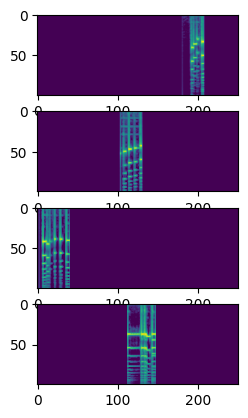

In [12]:
# MFCC plot

fig, axes = plt.subplots(4,1)

axes[0].imshow(mels_waves[0])
axes[1].imshow(mels_waves[10])
axes[2].imshow(mels_waves[20])
axes[3].imshow(mels_waves[200])

In [12]:
# Fast Fourier Transform (linear scale)
# we use only the amplitude values

fft_waves = []
for w in waves:
    amp = np.fft.rfft(w)[:-1]
    amp = abs(amp)*(2/len(amp))
    amp = amp[:len(amp)//2]
    amp = np.expand_dims(amp, axis=-1)
    fft_waves.append(amp)

print(np.array(fft_waves).shape)

(8184,)


/tmp/ipykernel_1847/242862058.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(fft_waves).shape)


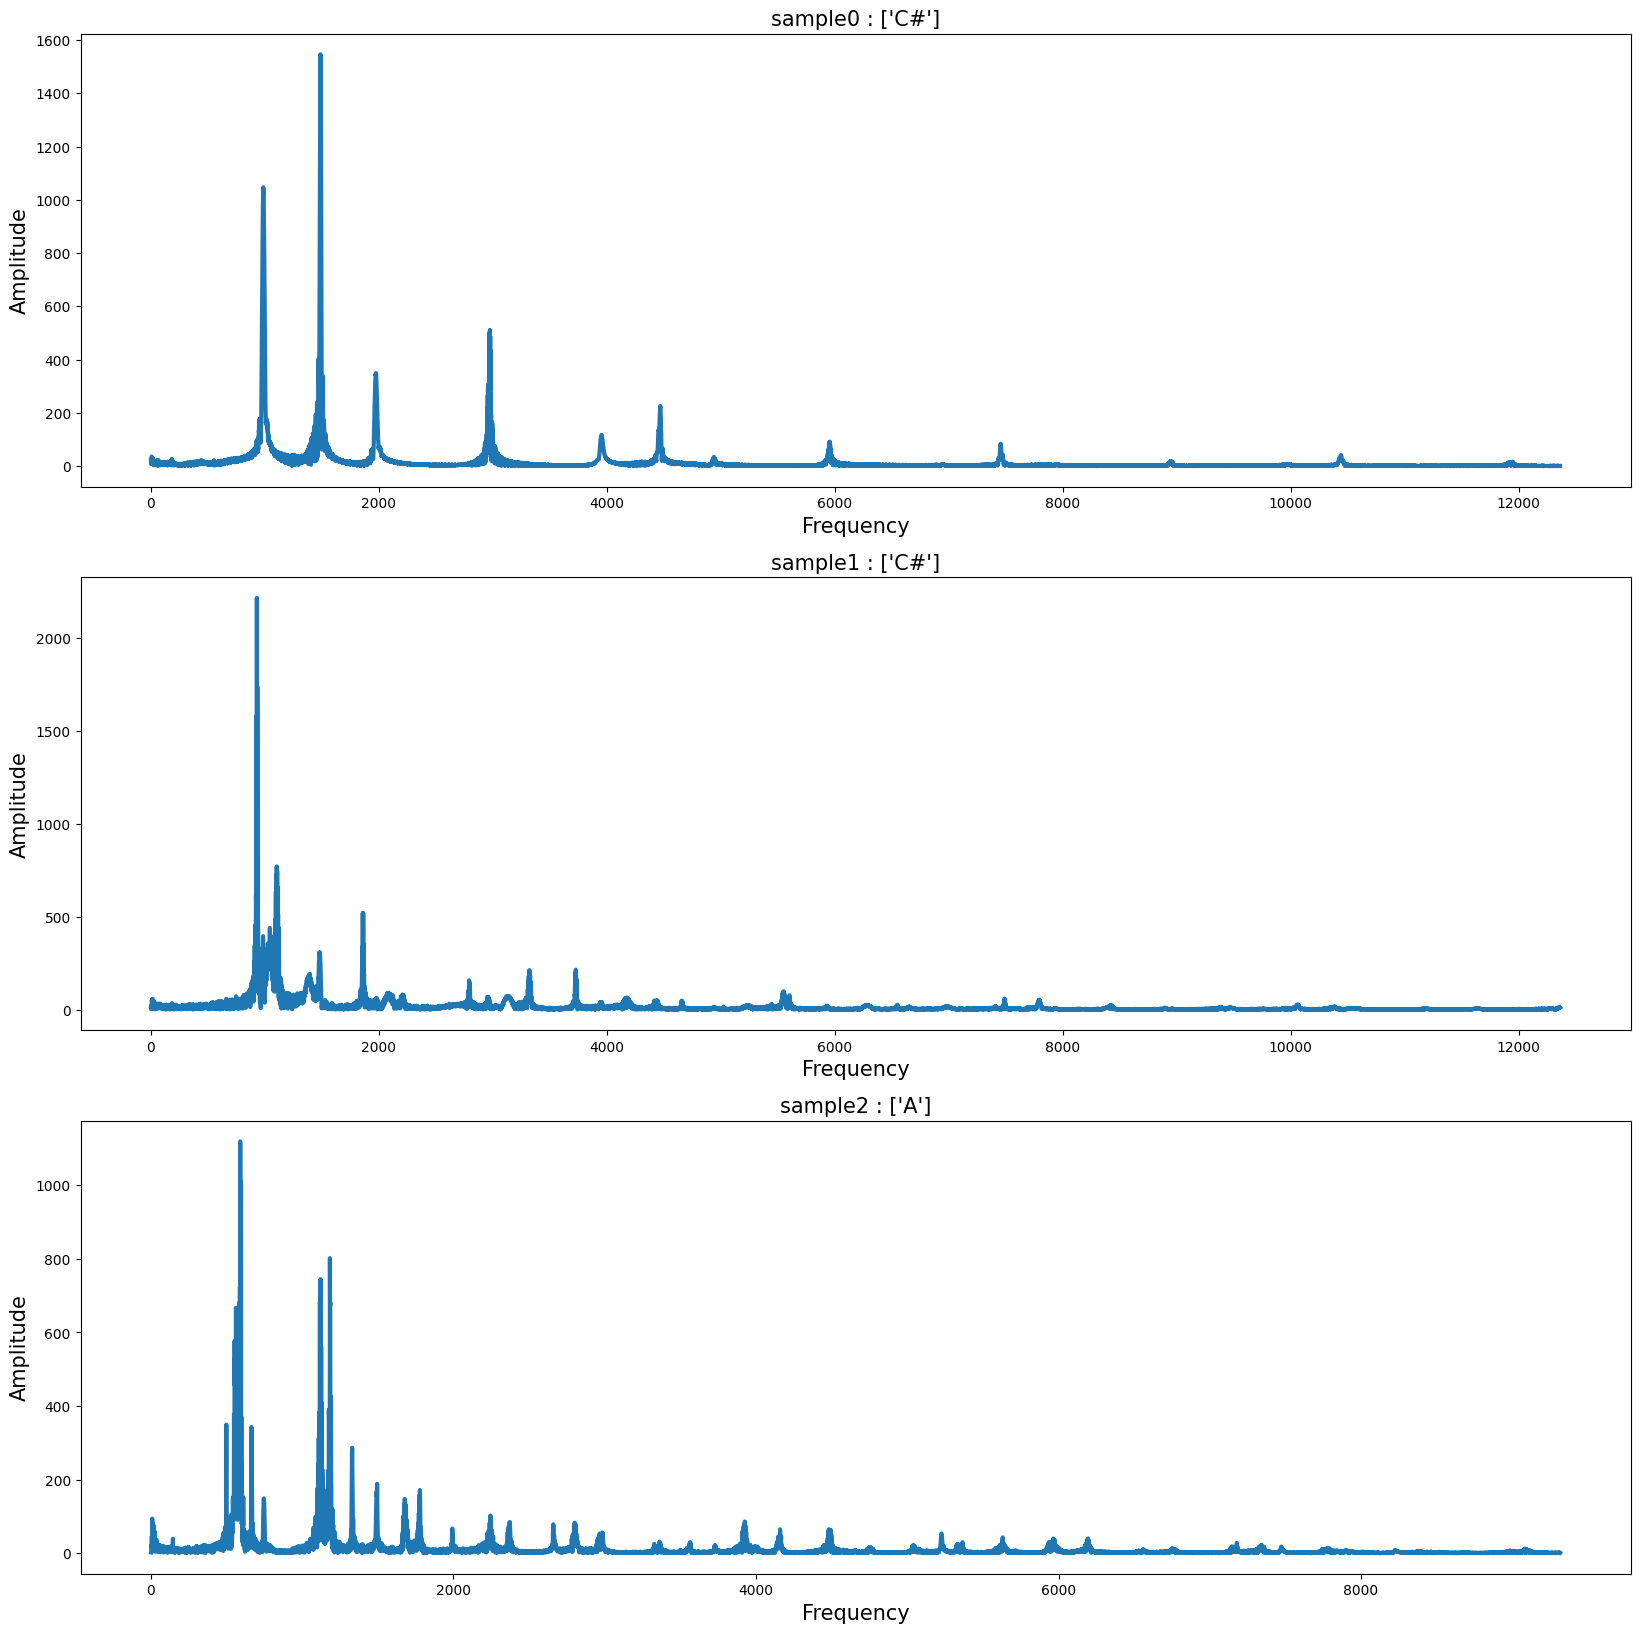

In [13]:
fig, axes = plt.subplots(3,1, figsize = (20,20))

wave_10_chord = le_chords.inverse_transform(targets[16].tolist())
wave_20_chord = le_chords.inverse_transform(targets[23].tolist())
wave_30_chord = le_chords.inverse_transform(targets[74].tolist())

axes[0].plot(fft_waves[16], linewidth = 3)
axes[0].set_title("sample0 : {}".format(wave_10_chord), fontsize = 15)
axes[0].set_xlabel('Frequency', fontsize = 15)
axes[0].set_ylabel('Amplitude', fontsize = 15)

axes[1].plot(fft_waves[23], linewidth = 3)
axes[1].set_title("sample1 : {}".format(wave_20_chord), fontsize = 15)
axes[1].set_xlabel('Frequency', fontsize = 15)
axes[1].set_ylabel('Amplitude', fontsize = 15)

axes[2].plot(fft_waves[74], linewidth = 3)
axes[2].set_title("sample2 : {}".format(wave_30_chord), fontsize = 15)
axes[2].set_xlabel('Frequency', fontsize = 15)
axes[2].set_ylabel('Amplitude', fontsize = 15)

plt.show()

In [14]:
# compress with max pooling and crop the range of useful features

goal_len = 1000

mp_fft_waves = []
for w in fft_waves:
    win_size, cut = divmod(len(w), goal_len)
    max_vals = []
    for i in range(0, len(w)-cut, win_size):
        window = w[i:i+win_size]
        max_val = max(window)
        max_vals.append(max_val)
    
    mp_fft_waves.append(np.array(max_vals[:300]))

print(np.array(mp_fft_waves).shape)

(8184, 300, 1)


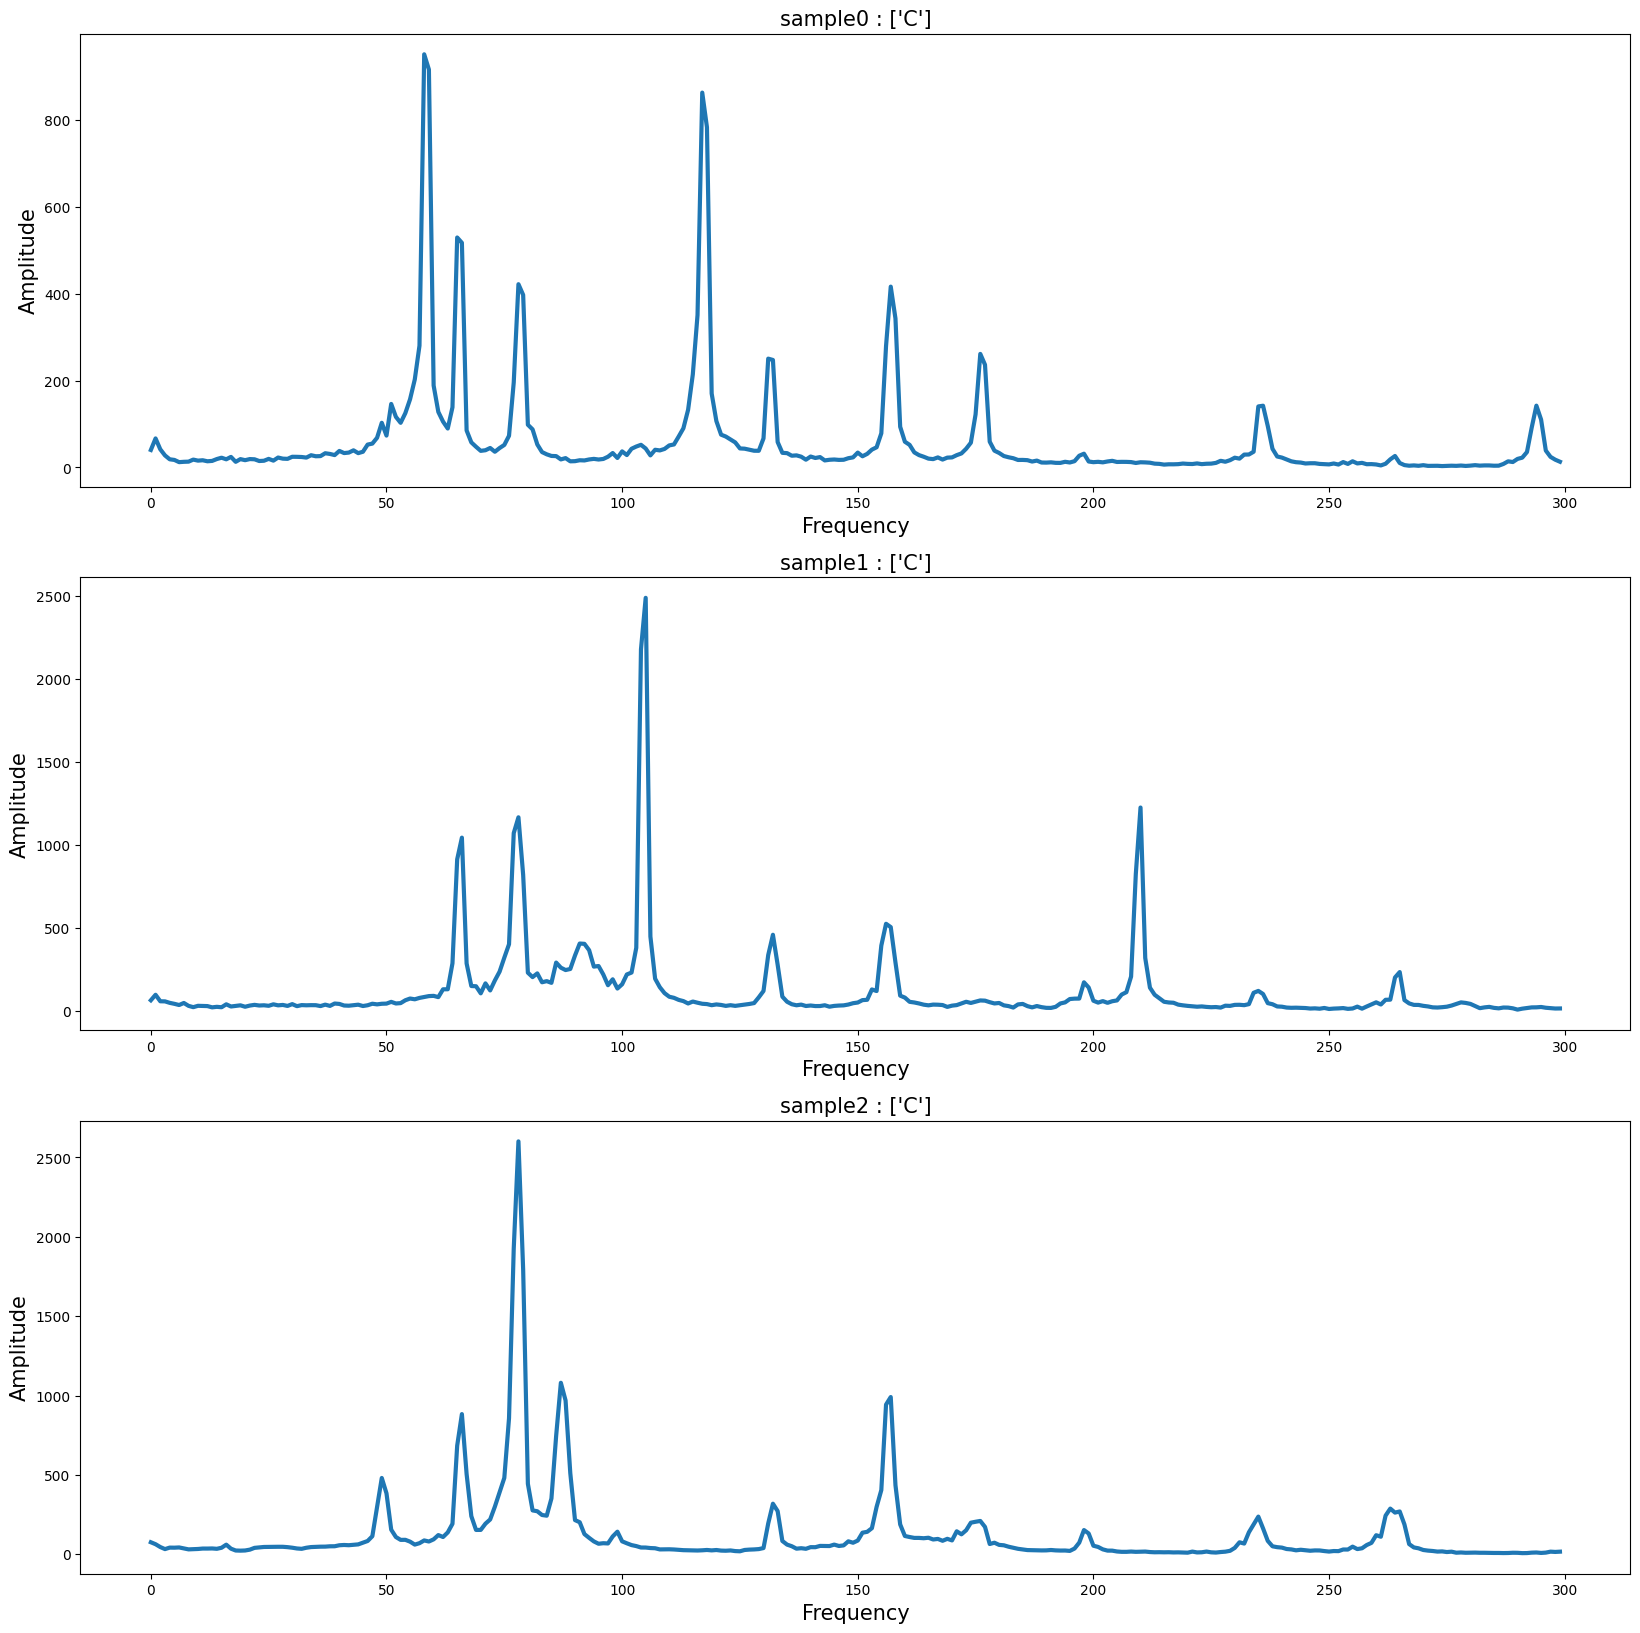

In [15]:
fig, axes = plt.subplots(3,1, figsize = (20,20))

wave_10_chord = le_chords.inverse_transform(targets[0].tolist())
wave_20_chord = le_chords.inverse_transform(targets[5].tolist())
wave_30_chord = le_chords.inverse_transform(targets[8].tolist())

axes[0].plot(mp_fft_waves[0], linewidth = 3)
axes[0].set_title("sample0 : {}".format(wave_10_chord), fontsize = 15)
axes[0].set_xlabel('Frequency', fontsize = 15)
axes[0].set_ylabel('Amplitude', fontsize = 15)

axes[1].plot(mp_fft_waves[5], linewidth = 3)
axes[1].set_title("sample1 : {}".format(wave_20_chord), fontsize = 15)
axes[1].set_xlabel('Frequency', fontsize = 15)
axes[1].set_ylabel('Amplitude', fontsize = 15)

axes[2].plot(mp_fft_waves[8], linewidth = 3)
axes[2].set_title("sample2 : {}".format(wave_30_chord), fontsize = 15)
axes[2].set_xlabel('Frequency', fontsize = 15)
axes[2].set_ylabel('Amplitude', fontsize = 15)

plt.show()

{3: 0.91202, 10: 0.89736, 0: 0.92375, 7: 0.91496, 8: 0.90616, 4: 0.91496, 9: 0.92962, 2: 0.93548, 1: 0.90909, 6: 0.91496, 11: 0.91202, 5: 0.92962}


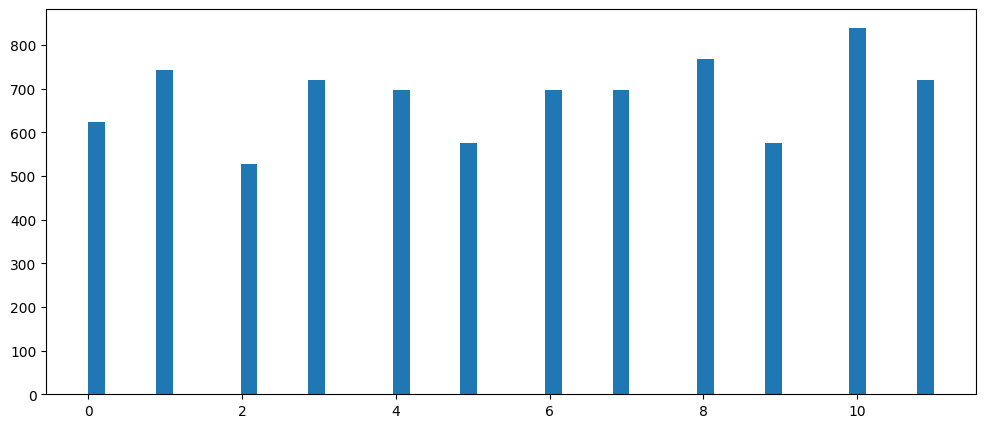

In [16]:
# get class weights for imbalanced data

from collections import Counter

cnvt_targets = targets.copy()
cnvt_targets = list(map(int,cnvt_targets))

size = len(cnvt_targets)
values_count = Counter(cnvt_targets)
class_weights = {}
for k in values_count.keys():
    class_weights[k] = round(1-(values_count[k]/size), 5)

print(class_weights)

plt.figure(figsize=(12,5))
plt.hist(cnvt_targets, bins=50)
plt.show()

In [17]:
# data split and get batch

# train_waves, val_waves, train_targets, val_targets = train_test_split(fft_waves, targets, test_size = 0.3, stratify=targets)
# train_waves, val_waves, train_targets, val_targets = train_test_split(mels_waves, targets, test_size = 0.3, stratify=targets)
# train_waves, val_waves, train_targets, val_targets = train_test_split(mfcc_waves, targets, test_size = 0.3, stratify=targets)
train_waves, val_waves, train_targets, val_targets = train_test_split(mp_fft_waves, targets, test_size = 0.3, stratify=targets)

train_set = tf.data.Dataset.from_tensor_slices((train_waves, train_targets)).shuffle(2000).batch(32)
val_set = tf.data.Dataset.from_tensor_slices((val_waves, val_targets)).shuffle(2000).batch(32)

2023-01-03 11:28:21.522945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-03 11:28:21.522966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (biosis6): /proc/driver/nvidia/version does not exist
2023-01-03 11:28:21.523735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Input, Activation, BatchNormalization, concatenate, Dropout

from tensorflow.keras.optimizers import Adam

from attention import Attention

In [19]:
# base model

def Convolution_model(input_shape, n_class):
    input_ = Input(shape = input_shape)

    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu')(input_)
    X = BatchNormalization()(X)
    X = Dropout(rate = 0.2)(X)

    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(rate = 0.2)(X)
    
    X = LSTM(units = 64, return_sequences = True)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate = 0.2)(X)
    
    X = LSTM(units = 64, return_sequences = True)(X) 
    X = Attention(128)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate = 0.2)(X)
    
    X = Dense(n_class, activation='softmax')(X)

    model = Model(inputs = input_, outputs = X)

    return model


def Inception_block_2D(x):
    '''
    for mel-spectrogram and mfcc
    '''
    
    Conv1x1 = Conv2D(8, kernel_size = (1,1), padding='same', activation = 'relu')(x)

    Conv3x3_dim_reduce = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(x)
    Conv3x3 = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(Conv3x3_dim_reduce)

    Conv5x5_dim_reduce = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(x)
    Conv5x5 = Conv2D(32, kernel_size = (5,5), padding = 'same', activation = 'relu')(Conv5x5_dim_reduce)
 
    Pooling = MaxPooling2D((3,3), strides = (1,1), padding = 'same')(x)
    Pooling = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(Pooling)

    x = concatenate([Conv1x1, Conv3x3, Conv5x5, Pooling])
    
    return x


def Inception_block_1D(x):
    '''
    for the raw signal or fft signal
    '''
    
    Conv1x1 = Conv1D(8, kernel_size = 1, padding='same', activation = 'relu')(x)

    Conv3x3_dim_reduce = Conv1D(64, kernel_size = 1, padding = 'same', activation = 'relu')(x)
    Conv3x3 = Conv1D(16, kernel_size = 3, padding = 'same', activation = 'relu')(Conv3x3_dim_reduce)

    Conv5x5_dim_reduce = Conv1D(128, kernel_size = 1, padding = 'same', activation = 'relu')(x)
    Conv5x5 = Conv1D(32, kernel_size = 5, padding = 'same', activation = 'relu')(Conv5x5_dim_reduce)
 
    Pooling = MaxPooling1D(3, strides = 1, padding = 'same')(x)
    Pooling = Conv1D(16, kernel_size = 1, padding = 'same', activation = 'relu')(Pooling)

    x = concatenate([Conv1x1, Conv3x3, Conv5x5, Pooling])
    
    return x



def Inception_model(input_shape, n_class):
    input_ = Input(shape = input_shape)

    X = Inception_block_1D(input_)
    X = Inception_block_1D(X)
    X = Inception_block_1D(X)
    
    
    output_ = GlobalAveragePooling1D()(X)
    output_ = Dense(units = 256, activation='relu')(output_)
    output_ = Dense(units = 128, activation='relu')(output_)
    output_ = Dense(units = 64, activation='relu')(output_)
    output_ = Dense(units = n_class, activation='softmax')(output_)             # chord size

    model = Model(inputs = input_, outputs = output_)

    return model


In [20]:
tf.keras.backend.clear_session()

### hyperparameters setting

In [21]:
input_shape = mp_fft_waves[0].shape
print(input_shape)
n_class = len(le_chords.classes_)

optimizer = Adam(learning_rate = 0.0005)
# model = Inception_model(input_shape, n_class)
model = Convolution_model(input_shape, n_class)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])

(300, 1)


### Experiment & result

In [22]:
EPOCH = 200

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(EPOCH):
    print('epoch : {}'.format(epoch+1))

    train_acc = 0.0
    train_loss = 0.0
    n = 0
    for i, data in enumerate(train_set):
        w = data[0]
        t = data[1]

        batch_loss = model.train_on_batch(w, t, class_weight=class_weights)
        # batch_loss = model.train_on_batch(w, t)
        # print('train')
        # pred = model.predict(w)
        # print(pred[0])

        train_acc += batch_loss[1]
        train_loss += batch_loss[0]
        n +=1

    train_acc_list.append(train_acc/n)
    train_loss_list.append(train_loss/n)

    val_acc = 0.0
    val_loss = 0.0
    m = 0
    for i, data in enumerate(val_set):
        w = data[0]
        t = data[1]
        
        batch_loss = model.test_on_batch(w, t)
#         print('test')
#         pred = model.predict(w)
#         print(pred[0])
        
        val_acc += batch_loss[1]
        val_loss += batch_loss[0]
        m +=1

    val_acc_list.append(val_acc/m)
    val_loss_list.append(val_loss/m)

    print("Model A | train acc : {:.4f}, train loss : {:.4f}, val acc : {:.4f}, val loss : {:.4f} |".format(
        (train_acc/n), (train_loss/n), (val_acc/m), (val_loss/m)))


epoch : 1


2023-01-03 11:29:32.884256: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-01-03 11:29:50.513292: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX S

Model A | train acc : 0.1035, train loss : 2.5048, val acc : 0.1136, val loss : 2.4709 |
epoch : 2
Model A | train acc : 0.1163, train loss : 2.3798, val acc : 0.1011, val loss : 2.4381 |
epoch : 3
Model A | train acc : 0.1198, train loss : 2.3513, val acc : 0.1483, val loss : 2.4359 |
epoch : 4
Model A | train acc : 0.1224, train loss : 2.3454, val acc : 0.1496, val loss : 2.4260 |
epoch : 5
Model A | train acc : 0.1297, train loss : 2.3130, val acc : 0.1385, val loss : 2.4585 |
epoch : 6
Model A | train acc : 0.1437, train loss : 2.2766, val acc : 0.1502, val loss : 2.4241 |
epoch : 7
Model A | train acc : 0.1433, train loss : 2.2737, val acc : 0.1335, val loss : 2.4357 |
epoch : 8
Model A | train acc : 0.1482, train loss : 2.2556, val acc : 0.1416, val loss : 2.4058 |
epoch : 9
Model A | train acc : 0.1594, train loss : 2.2282, val acc : 0.1654, val loss : 2.3813 |
epoch : 10
Model A | train acc : 0.1639, train loss : 2.2139, val acc : 0.1588, val loss : 2.3714 |
epoch : 11
Model A 

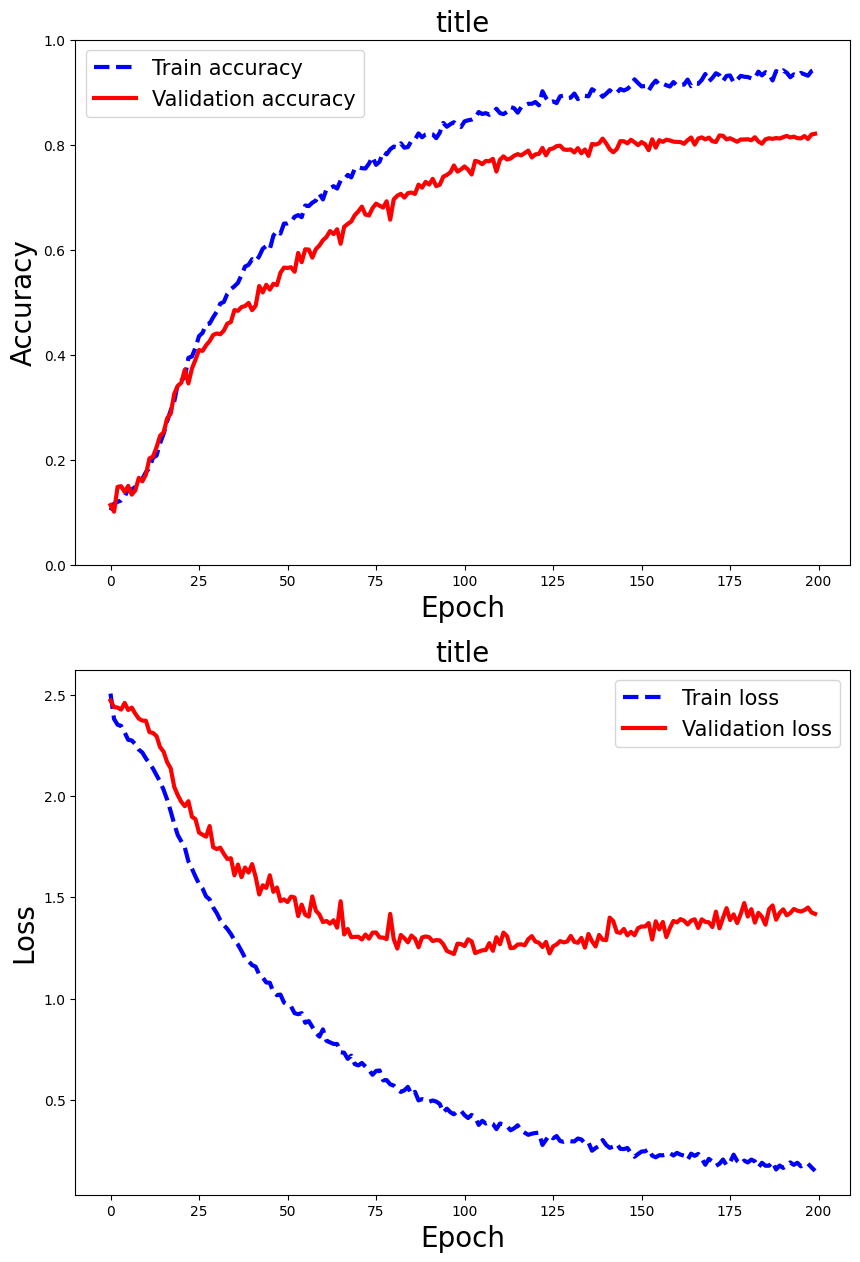

In [23]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize = (10,15))

axes[0].plot(train_acc_list, c = 'b', linestyle = 'dashed', linewidth = 3)
axes[0].plot(val_acc_list, c = 'r', linestyle = 'solid', linewidth = 3)

axes[0].set_ylim(0,1)

axes[0].set_title("title", fontsize=20)
axes[0].set_xlabel('Epoch', fontsize = 20)
axes[0].set_ylabel('Accuracy', fontsize = 20)

axes[0].legend(['Train accuracy', 'Validation accuracy'], fontsize = 15)


axes[1].plot(train_loss_list, c = 'b', linestyle = 'dashed', linewidth = 3)
axes[1].plot(val_loss_list, c = 'r', linestyle = 'solid', linewidth = 3)

# axes[1].set_ylim(0.2,1)

axes[1].set_title("title", fontsize=20)
axes[1].set_xlabel('Epoch', fontsize = 20)
axes[1].set_ylabel('Loss', fontsize = 20)

axes[1].legend(['Train loss', 'Validation loss'], fontsize = 15)